<a href="https://colab.research.google.com/github/jenny005/Reinforcement-Learning-by-Sutton-Barto/blob/main/Chapter_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 5 : Monte Carlo Methods

### Example 5.1 : Blackjack (Fixed Policy)

In [ ]:
#-----------------------------------------------------------------------Example 5.1 : Blackjack (Fixed Policy)------------------------------------------------------------------------

# 1. Environment Setup

import random
from collections import defaultdict

# Draw a card: 1–10 (4 of each), face cards = 10
def draw_card():
    return min(random.randint(1, 13), 10) # J is 11, Q is 12, K is 13, but all faces are set to 10

def draw_hand(): # A hand has 2 cards
    return [draw_card(), draw_card()] # return a list like: Hand 1: [1, 10], Hand 2: [3, 9]

def usable_ace(hand):  # Checks if the player has at least one Ace. Normally, an Ace counts as 1
    return 1 in hand and sum(hand) + 10 <= 21  # If we add 10, the total<=21, we're effectively counting it as 11. Then the Aces is usable, return 1 means True.

def sum_hand(hand):
    total = sum(hand)
    if usable_ace(hand):
        return total + 10
    return total

def is_bust(hand): # count the sum of hand card to decide bust or not
    return sum_hand(hand) > 21

def get_state(player_hand, dealer_card): # Input = player's hand and dealer's show card, Output = State = player's hand total, dealer showing card, usable ace in player hand or not
    return (sum_hand(player_hand), dealer_card, usable_ace(player_hand))


# 2. Define Policy (Stick if sum>=20)

def policy(player_sum): # Under the policy: input=player sum, output=action: 0=stick or 1=hit
    return 0 if player_sum >= 20 else 1  # 0 = stick, 1 = hit

# 3. Simulate a full episode under that policy

def play_episode(): # episode = A sequence of (state, action, reward) triplets that describe the full game from start to end
    player = draw_hand() # player is a list like: Hand 1: [1, 10], Hand 2: [3, 9]
    dealer = draw_hand() # dealer is a list like: Hand 1: [2, 5], Hand 2: [4, J]
    dealer_showing = dealer[0]

    episode = [] # initializes an empty list to store the full trajectory of a Blackjack episode
    state = get_state(player, dealer_showing) # state = (sum_hand(player_hand), dealer showing card, usable_ace(player_hand))

    # Player's turn
    while True:
        player_sum = state[0] # state[0]=sum_hand(player_hand)
        action = policy(player_sum) # action: 0 = stick, 1 = hit
        episode.append((state, action))  # episode=[(state1,action1),(state2,action2),...]
        if action == 0:
            break  # Stick
        player.append(draw_card()) # not break means hit, player continue to draw a card
        if is_bust(player):
            return episode, -1  # Player loses
        state = get_state(player, dealer_showing)

    # Dealer's turn
    while sum_hand(dealer) < 17: # Dealer's policy = Must hit if sum < 17
        dealer.append(draw_card())
    if is_bust(dealer):
        return episode, 1  # Player wins

    # Compare final sums
    player_sum = sum_hand(player)
    dealer_sum = sum_hand(dealer)
    if player_sum > dealer_sum:
        return episode, 1  # Player wins
    elif player_sum < dealer_sum:
        return episode, -1 # Dealer wins
    else:
        return episode, 0  # Player and Dealer draw

# 4. First-Visit Monte Carlo Prediction

def mc_prediction(policy, num_episodes=500000):
    V = defaultdict(float) # V={state1: value-function1, state2: value-function2}
    returns_sum = defaultdict(float)
    returns_count = defaultdict(int)

    for _ in range(num_episodes):
        episode, reward = play_episode() # play_episode return episode1=[(state1,action1)], reward1
        visited_states = set() # Ensure first-visit MC behavior by updating values only the first time a state is seen in an episode.

        for idx, (state, _) in enumerate(episode):
            if state not in visited_states: # first-visit average
                visited_states.add(state)
                returns_sum[state] += reward
                returns_count[state] += 1
                V[state] = returns_sum[state] / returns_count[state]

    return V  # V is the player dict, key is state=(sum_hand(player_hand), dealer showing card, usable_ace(player_hand)), value is a ratio which is state-value function for the policy

# 5. Run the Monte Carlo Prediction

V = mc_prediction(policy, num_episodes=300000)

# Example: print value for state with player sum 20, dealer showing 10, usable ace
print("Value of (20, 10, True):", round(V.get((20, 10, True), 0), 3)) # (20, 10, True):player hand sum=20,dealer showing card=10, ace usable: 0.443 = the estimated expected return from this state under your policy



In [ ]:
# 6. Plot Player's value function
policy_dict = {}

for player_sum in range(12, 22): # player hand cards sum
    for dealer_card in range(1, 11): # dealer showing card
        for usable in [False, True]:
            state = (player_sum, dealer_card, usable)
            policy_dict[state] = policy(player_sum)


In [ ]:
import matplotlib.pyplot as plt

def plot_policy_with_values(policy_dict, V):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    action_labels = ['Hit', 'Stick']
    ace_labels = ['No Usable Ace', 'Usable Ace']
    colors = {1: 'cyan', 0: 'lime'}

    for row, action in enumerate([1, 0]):  # Top = Hit, Bottom = Stick
        for col, usable_ace in enumerate([False, True]):
            ax = axes[row][col]
            ax.set_facecolor('black')
            ax.set_title(f"{ace_labels[col]}", fontsize=14, color='white')

            for dealer in range(1, 11):
                for player in range(12, 22):
                    state = (player, dealer, usable_ace)
                    policy_action = policy_dict.get(state, 0)
                    value = V.get(state, 0.0)

                    # Only plot if this subplot matches the action
                    if policy_action == action:
                        display_text = f"{action}\n{value:.3f}"
                        ax.text(player - 12, dealer - 1, display_text,
                                ha='center', va='center',
                                color=colors[action],
                                fontsize=9, fontweight='bold')

            # Ticks and labels
            ax.set_xticks(range(10))
            ax.set_xticklabels(range(12, 22), color='white')
            ax.set_yticks(range(10))
            ax.set_yticklabels(['A'] + list(range(2, 11)), color='white')
            ax.set_xlim(-0.5, 9.5)
            ax.set_ylim(-0.5, 9.5)
            ax.invert_yaxis()
            ax.set_xlabel("Player Sum", color='white')
            ax.set_ylabel("Dealer Showing", color='white')
            for spine in ax.spines.values():
                spine.set_edgecolor('white')

            # Add row label (Hit/Stick)
            ax.text(-1.8, 4.5, action_labels[row],
                    color='white', fontsize=14, rotation=90,
                    va='center', ha='center')

    fig.patch.set_facecolor('black')
    plt.tight_layout()
    plt.show()

# Player sum=16, Dealer showing=10, the value function=-0.593, implies that you lose roughly 59% more often than you win — and your overall chance of losing is well over 70% in that state.

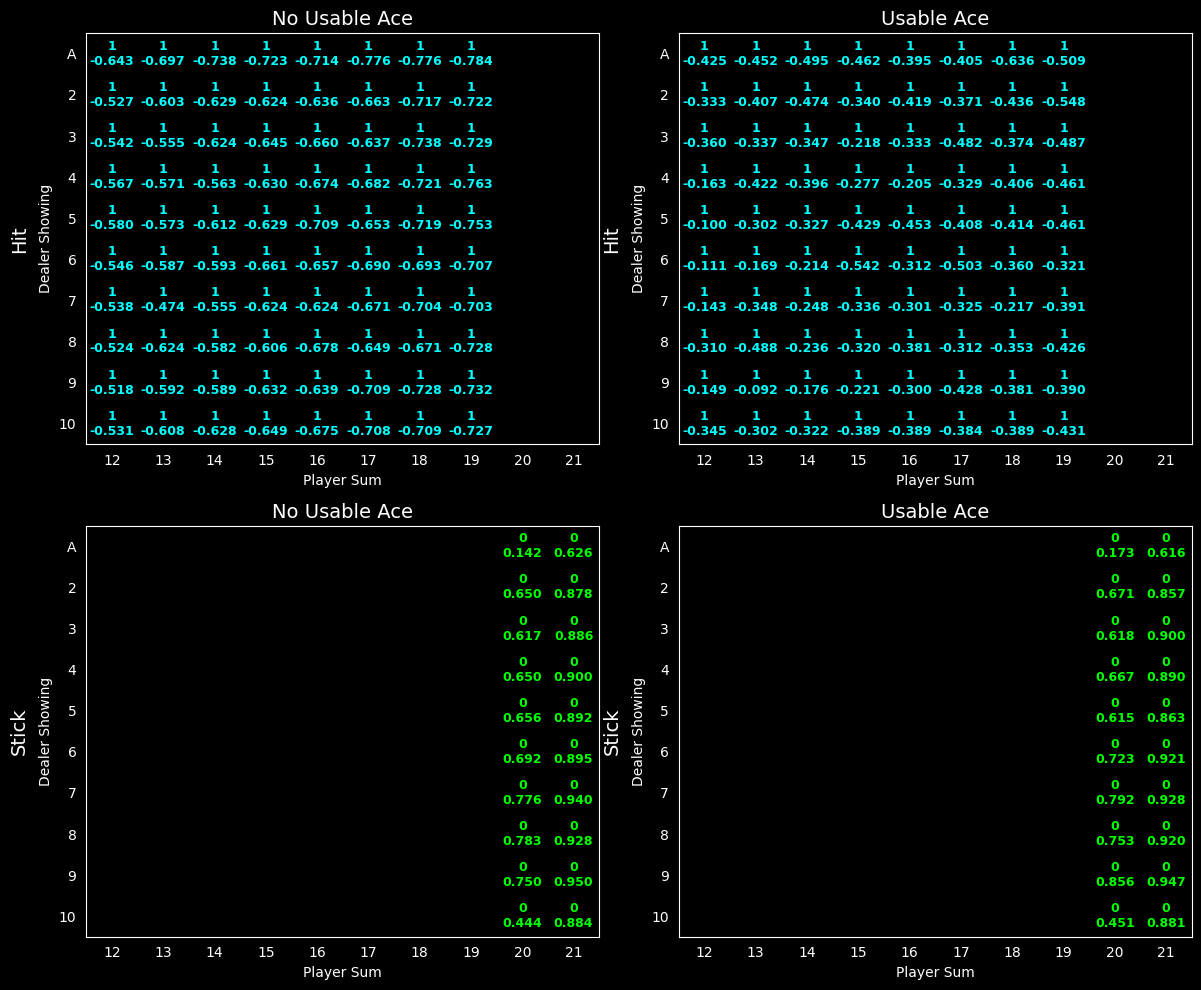

In [ ]:
V = mc_prediction(policy=..., num_episodes=100000)
plot_policy_with_values(policy_dict, V) # player sum=20, dealer showing=10, no usable ace=0.42, usable ace=0.443,  means Ace flip to 11 have more value function than 1


In [ ]:
import matplotlib.pyplot as plt

def plot_policy_value_2panel(policy_dict, V):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    titles = ['No Usable Ace', 'Usable Ace']
    colors = {1: 'cyan', 0: 'lime'}

    for col, usable_ace in enumerate([False, True]):
        ax = axes[col]
        ax.set_facecolor('black')
        ax.set_title(titles[col], fontsize=14, color='white')

        for dealer in range(1, 11):
            for player in range(12, 22):
                state = (player, dealer, usable_ace)
                action = policy_dict.get(state, 0)
                value = V.get(state, 0.0)
                display_text = f"{action}\n{value:.3f}"

                ax.text(player - 12, dealer - 1, display_text,
                        ha='center', va='center',
                        color=colors[action], fontsize=9, fontweight='bold')

        # Ticks and labels
        ax.set_xticks(range(10))
        ax.set_xticklabels(range(12, 22), color='white')
        ax.set_yticks(range(10))
        ax.set_yticklabels(['A'] + list(range(2, 11)), color='white')
        ax.set_xlim(-0.5, 9.5)
        ax.set_ylim(-0.5, 9.5)
        ax.invert_yaxis()
        ax.set_xlabel("Player Sum", color='white')
        ax.set_ylabel("Dealer Showing", color='white')
        for spine in ax.spines.values():
            spine.set_edgecolor('white')

    fig.patch.set_facecolor('black')
    plt.tight_layout()
    plt.show()


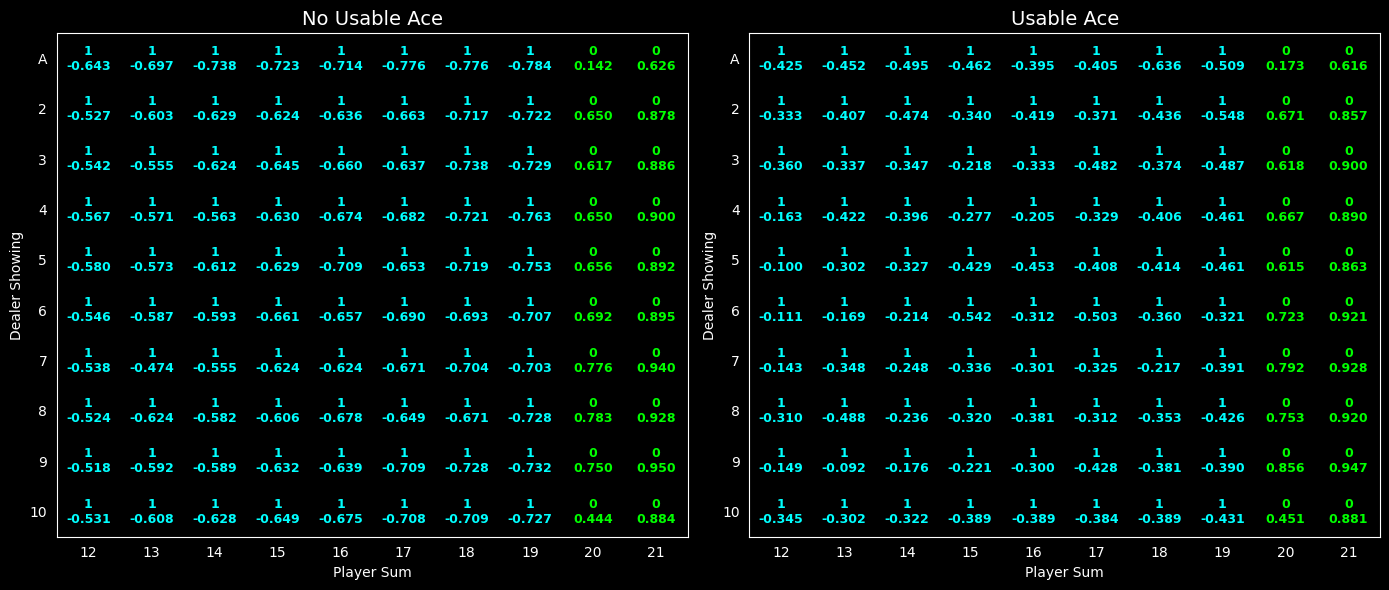

In [ ]:
plot_policy_value_2panel(policy_dict, V)


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_policy_value_3d(policy_dict, V):
    fig = plt.figure(figsize=(16, 6))

    ace_labels = ['No Usable Ace', 'Usable Ace']
    colors = {0: 'lime', 1: 'cyan'}

    for i, usable_ace in enumerate([False, True]):
        ax = fig.add_subplot(1, 2, i + 1, projection='3d')
        ax.set_title(ace_labels[i], fontsize=14)

        X, Y, Z, C = [], [], [], []

        for player in range(12, 22):
            for dealer in range(1, 11):
                state = (player, dealer, usable_ace)
                value = V.get(state, 0.0)
                action = policy_dict.get(state, 0)

                X.append(player)
                Y.append(dealer)
                Z.append(value)
                C.append(colors[action])

        ax.scatter(X, Y, Z, c=C, s=60, edgecolors='k', depthshade=True)
        ax.set_xlabel("Player Sum")
        ax.set_ylabel("Dealer Showing")
        ax.set_zlabel("Value")
        ax.set_zlim(-1, 1)
        ax.view_init(elev=25, azim=225)

    plt.tight_layout()
    plt.show()


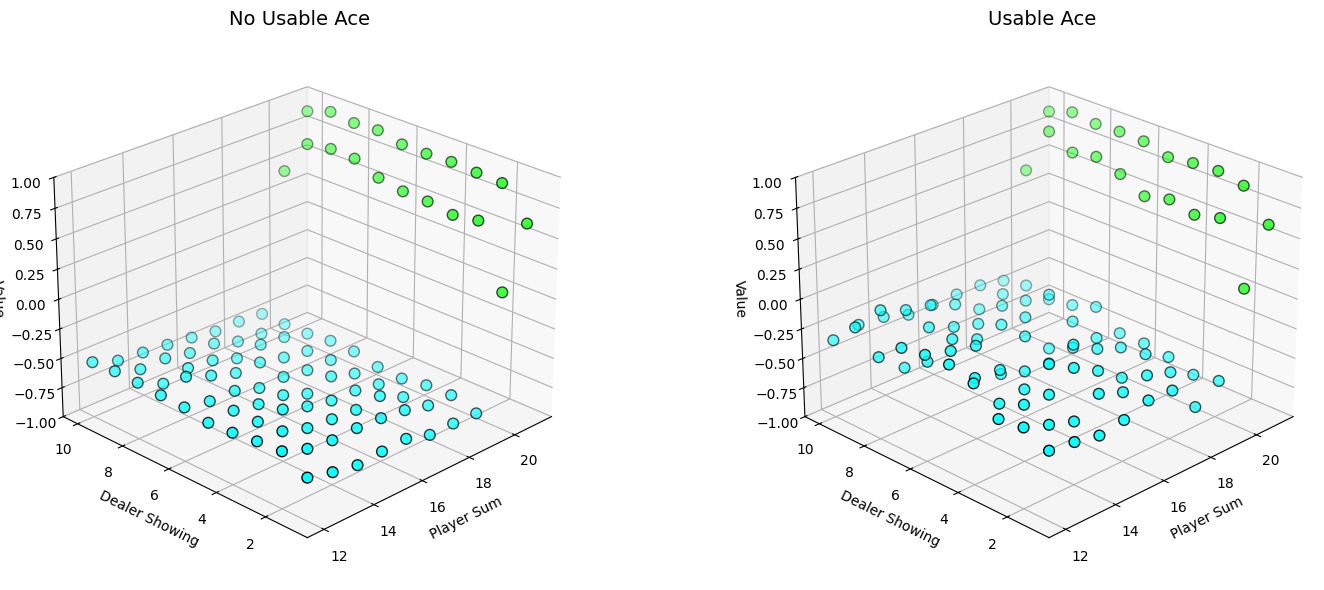

In [ ]:
plot_policy_value_3d(policy_dict, V)


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_value_surface(V):
    fig = plt.figure(figsize=(14, 6))
    ace_labels = ['No Usable Ace', 'Usable Ace']

    x = np.arange(12, 22)
    y = np.arange(1, 11)
    X, Y = np.meshgrid(x, y)

    # Prepare surfaces for both ace cases
    surfaces = []
    for i, usable_ace in enumerate([False, True]):
        Z = np.zeros_like(X, dtype=float)
        for xi in range(len(x)):
            for yi in range(len(y)):
                state = (x[xi], y[yi], usable_ace)
                Z[yi, xi] = V.get(state, 0.0)

        ax = fig.add_subplot(1, 2, i + 1, projection='3d')
        ax.set_title(ace_labels[i], fontsize=14)
        surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k', linewidth=0.5)
        surfaces.append(surf)

        ax.set_xlabel('Player sum')
        ax.set_ylabel('Dealer showing')
        ax.set_zlabel('Value')
        ax.set_zlim(-1, 1)
        ax.view_init(elev=30, azim=225)

    # Create a single colorbar on the right side
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    fig.colorbar(surfaces[0], cax=cbar_ax)

    plt.subplots_adjust(left=0.05, right=0.9, wspace=0.25)
    plt.show()


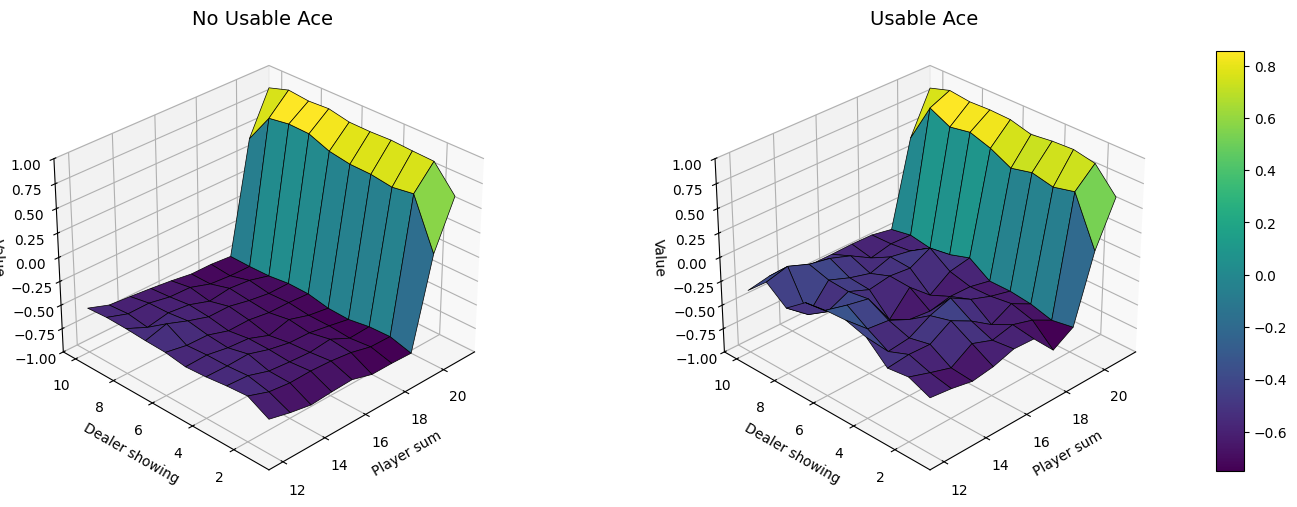

In [ ]:
plot_value_surface(V)


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_value_surface_4panel(V_10k, V_500k):
    fig = plt.figure(figsize=(16, 10))
    x = np.arange(12, 22)
    y = np.arange(1, 11)
    X, Y = np.meshgrid(x, y)

    value_sets = [
        (V_10k, "After 10,000 episodes"),
        (V_500k, "After 500,000 episodes")
    ]

    for col, (V, title) in enumerate(value_sets):
        for row, usable_ace in enumerate([True, False]):  # Top = usable, Bottom = no usable
            Z = np.zeros_like(X, dtype=float)
            for xi in range(len(x)):
                for yi in range(len(y)):
                    state = (x[xi], y[yi], usable_ace)
                    Z[yi, xi] = V.get(state, 0.0)

            ax = fig.add_subplot(2, 2, row * 2 + col + 1, projection='3d')
            ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k', linewidth=0.5)
            ax.set_zlim(-1, 1)
            ax.view_init(elev=30, azim=225)
            ax.set_xlabel('Player sum')
            ax.set_ylabel('Dealer showing')
            ax.set_zlabel('Value')

            if row == 0:
                ax.set_title(title, fontsize=14)
            if col == 0:
                ax.text2D(-0.15, 0.5, "Usable ace" if row == 0 else "No usable ace",
                          transform=ax.transAxes, fontsize=12, rotation=90,
                          verticalalignment='center')

    plt.tight_layout()
    plt.show()


In [ ]:
V_10k = mc_prediction(policy=..., num_episodes=10000)
V_500k = mc_prediction(policy=..., num_episodes=500000)


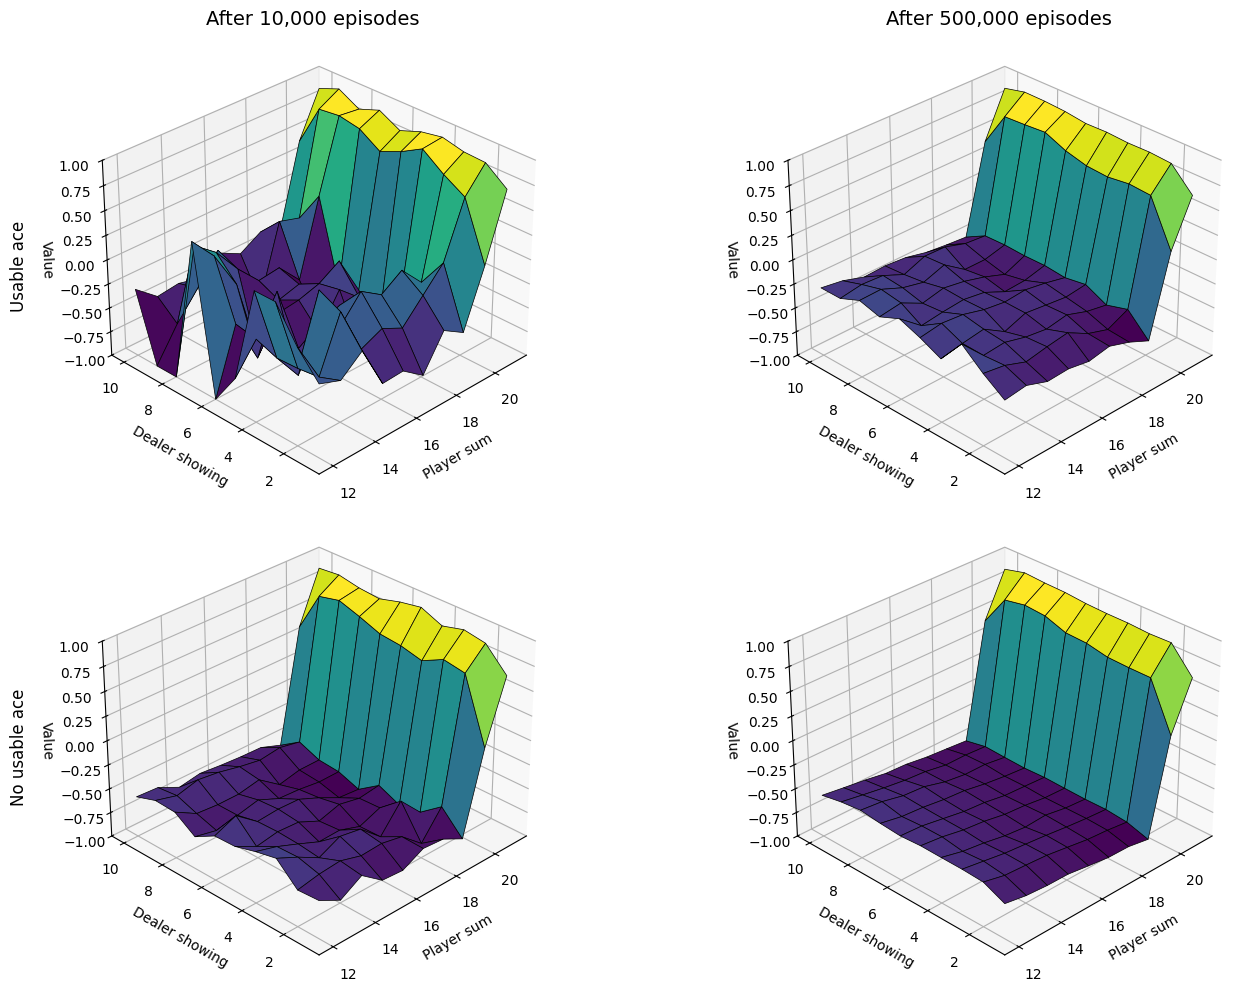

In [ ]:
plot_value_surface_4panel(V_10k, V_500k)


### Example 5.3 : Blackjack --- Monte Carlo ES (Exploring Starts), for estimating optimal policy

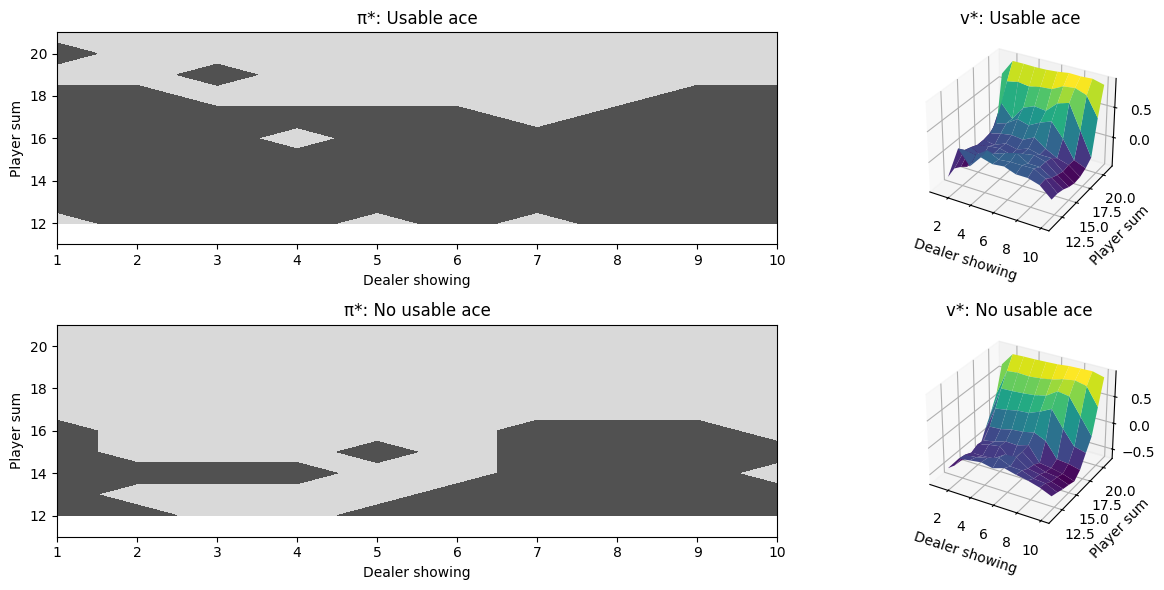

In [ ]:
# ----------------------------------------------------Example 5.3 : Blackjack --- Monte Carlo ES (Exploring Starts), for estimating optimal policy-------------------------------------------------
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D

# ----------- 1. Blackjack Environment -----------

def draw_card():
    return min(random.randint(1, 13), 10)

def draw_hand():
    return [draw_card(), draw_card()]

def usable_ace(hand):
    return 1 in hand and sum(hand) + 10 <= 21

def sum_hand(hand):
    return sum(hand) + 10 if usable_ace(hand) else sum(hand)

def is_bust(hand):
    return sum_hand(hand) > 21

def get_state(player_hand, dealer_card):
    return (sum_hand(player_hand), dealer_card, usable_ace(player_hand))

# ----------- 2. Monte Carlo Exploring Starts -----------
# Exploring Start assume every state-action pair has a non-zero chance of being started from
def mc_control_es(num_episodes=50000000): # Q[state][0] = estimated value of sticking, Q[state][1] = estimated value of hitting
    Q = defaultdict(lambda: np.zeros(2))  # Q(s,a) is a dict, the key is state, the value is all actions in that state: stick(0), hit(1), q_value = Q[state][action], the action is the index of that state
    N = defaultdict(lambda: np.zeros(2))  # N(s,count) is a dict, the key is state, the value is Visit count
    policy = defaultdict(lambda: random.choice([0, 1])) # policy(state,action) is not fixed but random choice, policy's value=action: 0=stick or 1=hit but policy's key are created on demand

    def play_episode_es():
        while True: # simulating random starting states
            player = draw_hand()
            dealer = draw_hand()
            state = get_state(player, dealer[0]) # dealer[0]=dealer showing card
            if 12 <= state[0] <= 21: # state[0]=player hand sum in[12,21] then break, otherwise re-deal a new full initial state: draw a new hand not just one card
                break
        # Player's turn
        action = random.choice([0, 1])
        episode = [(state, action)] # start in a state-action pair, every pair has a nonzero probability of being selected as the start
        if action == 1: # action: 0=stick or 1=hit
            player.append(draw_card())
            if is_bust(player):
                return episode, -1 # player loses
            state = get_state(player, dealer[0])
        while True:
            action = policy[state] # following the current policy, policy randomly fill in values(0 or 1) if a new key (state) is accessed.
            episode.append((state, action))
            if action == 0: # action: 0=stick or 1=hit
                break
            player.append(draw_card())
            if is_bust(player):
                return episode, -1
            state = get_state(player, dealer[0])
        # Dealer's turn
        while sum_hand(dealer) < 17:
            dealer.append(draw_card())
        if is_bust(dealer):
            return episode, 1    # play_episode_es() return episode, reward
        # Compare final sums
        player_sum = sum_hand(player)
        dealer_sum = sum_hand(dealer)
        if player_sum > dealer_sum:
            return episode, 1
        elif player_sum < dealer_sum:
            return episode, -1
        else:
            return episode, 0


    for _ in range(num_episodes):
        episode, reward = play_episode_es()
        visited = set() # first-visit MC
        for state, action in episode:
            if (state, action) not in visited:
                visited.add((state, action))
                N[state][action] += 1
                alpha = 1 / N[state][action]
                Q[state][action] += alpha * (reward - Q[state][action]) # Qn+1=Qn + 1/n[Rn-Qn] Book page 31, formula (2,3)
                policy[state] = np.argmax(Q[state])  # Updates the policy to be greedy w.r.t. the current Q-values.


    return policy, Q

# ----------- 3. Train the Agent -----------

policy_es, Q_es = mc_control_es(num_episodes=500000)

# ----------- 4. Extract π* and v* -----------

player_sums = np.arange(11, 22)
dealer_showing = np.arange(1, 11)
X, Y = np.meshgrid(dealer_showing, player_sums) # dealer_showing (x-axis)= [1, 2, ..., 10], player_sums (y-axis)=[11, 12, ..., 21]

Z_usable = np.full_like(X, np.nan, dtype=float)
Z_no_usable = np.full_like(X, np.nan, dtype=float)
policy_usable = np.full_like(X, np.nan, dtype=float)
policy_no_usable = np.full_like(X, np.nan, dtype=float)

for i, ps in enumerate(player_sums):
    for j, ds in enumerate(dealer_showing):
        for ace in [True, False]:
            state = (ps, ds, ace)
            if state in Q_es:
                best_action = np.argmax(Q_es[state])
                best_value = np.max(Q_es[state])
                if ace:
                    Z_usable[i, j] = best_value
                    policy_usable[i, j] = best_action
                else:
                    Z_no_usable[i, j] = best_value
                    policy_no_usable[i, j] = best_action

# ----------- 5. Plot π* and v* (Figure 5.2) -----------

fig = plt.figure(figsize=(14, 6))

# π*: Usable Ace
ax1 = fig.add_subplot(221)
ax1.set_title('π*: Usable ace')
ax1.contourf(dealer_showing, player_sums, policy_usable, cmap='Greys', levels=[-0.5, 0.5, 1.5])
ax1.set_xlabel('Dealer showing')
ax1.set_ylabel('Player sum')

# π*: No Usable Ace
ax2 = fig.add_subplot(223)
ax2.set_title('π*: No usable ace')
ax2.contourf(dealer_showing, player_sums, policy_no_usable, cmap='Greys', levels=[-0.5, 0.5, 1.5])
ax2.set_xlabel('Dealer showing')
ax2.set_ylabel('Player sum')

# v*: Usable Ace
ax3 = fig.add_subplot(222, projection='3d')
ax3.plot_surface(X, Y, Z_usable, cmap='viridis')
ax3.set_title('v*: Usable ace')
ax3.set_xlabel('Dealer showing')
ax3.set_ylabel('Player sum')

# v*: No Usable Ace
ax4 = fig.add_subplot(224, projection='3d')
ax4.plot_surface(X, Y, Z_no_usable, cmap='viridis')
ax4.set_title('v*: No usable ace')
ax4.set_xlabel('Dealer showing')
ax4.set_ylabel('Player sum')

plt.tight_layout()
plt.show()


In [ ]:
# Q = {
#     (13, 10, False): [ 0.0,  -1.0 ],
#     (18, 10, False): [-1.0,  0.0 ],
#     (20,  6,  True): [ 0.7, -0.3 ],
#     (12,  2, False): [-0.5,  0.1 ],
#     (17,  8, False): [-0.8,  0.0 ],
# }

# policy = {
#     (13, 10, False): 0,  # Stick (Q[0] = 0 > Q[1] = -1)
#     (18, 10, False): 1,  # Hit   (Q[1] = 0 > Q[0] = -1)
#     (20,  6,  True): 0,  # Stick (0.7 > -0.3)
#     (12,  2, False): 1,  # Hit   (0.1 > -0.5)
#     (17,  8, False): 1,  # Hit   (0.0 > -0.8)
# }


## On-policy first-visit MC control (for  ε-soft policy), estimates optimal policy

In [ ]:
#--------------------------------------------On-policy first-visit MC control (for ε-soft policy), estimates optimal policy-------------------------
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D

def draw_card():
    return min(random.randint(1, 13), 10)

def draw_hand():
    return [draw_card(), draw_card()]

def usable_ace(hand):
    return 1 in hand and sum(hand) + 10 <= 21

def sum_hand(hand):
    return sum(hand) + 10 if usable_ace(hand) else sum(hand)

def is_bust(hand):
    return sum_hand(hand) > 21

def get_state(player_hand, dealer_card):
    return (sum_hand(player_hand), dealer_card, usable_ace(player_hand))

def mc_control_on_policy_soft(num_episodes=500000, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(2))  # Two actions: stick(0), hit(1)
    N = defaultdict(lambda: np.zeros(2))
    policy = defaultdict(lambda: np.array([0.5, 0.5])) # initial policy 50% action=0, 50% action=1

    def generate_episode():
        # simulating random starting states
        player = draw_hand()
        dealer = draw_hand()
        episode = []
        state = get_state(player, dealer[0])

        # Player's turn
        while True:
            action = np.random.choice([0, 1], p=policy[state])
            episode.append((state, action))
            if action == 0:
                break
            player.append(draw_card())
            if is_bust(player):
                return episode, -1
            state = get_state(player, dealer[0])

        # Dealer's turn
        while sum_hand(dealer) < 17:
            dealer.append(draw_card())
        if is_bust(dealer):
            return episode, 1
        player_sum = sum_hand(player)
        dealer_sum = sum_hand(dealer)
        if player_sum > dealer_sum:
            return episode, 1
        elif player_sum < dealer_sum:
            return episode, -1
        else:
            return episode, 0

    for _ in range(num_episodes):
        episode, reward = generate_episode()
        G = reward
        visited = set()

        for state, action in episode:
            if (state, action) not in visited:
                visited.add((state, action))
                N[state][action] += 1
                alpha = 1 / N[state][action]
                Q[state][action] += alpha * (G - Q[state][action])

                best_action = np.argmax(Q[state])
                for a in [0, 1]:
                    if a == best_action:
                        policy[state][a] = 1 - epsilon + epsilon / 2
                    else:
                        policy[state][a] = epsilon / 2

    return policy, Q

policy_soft, Q_soft = mc_control_on_policy_soft(num_episodes=500000)


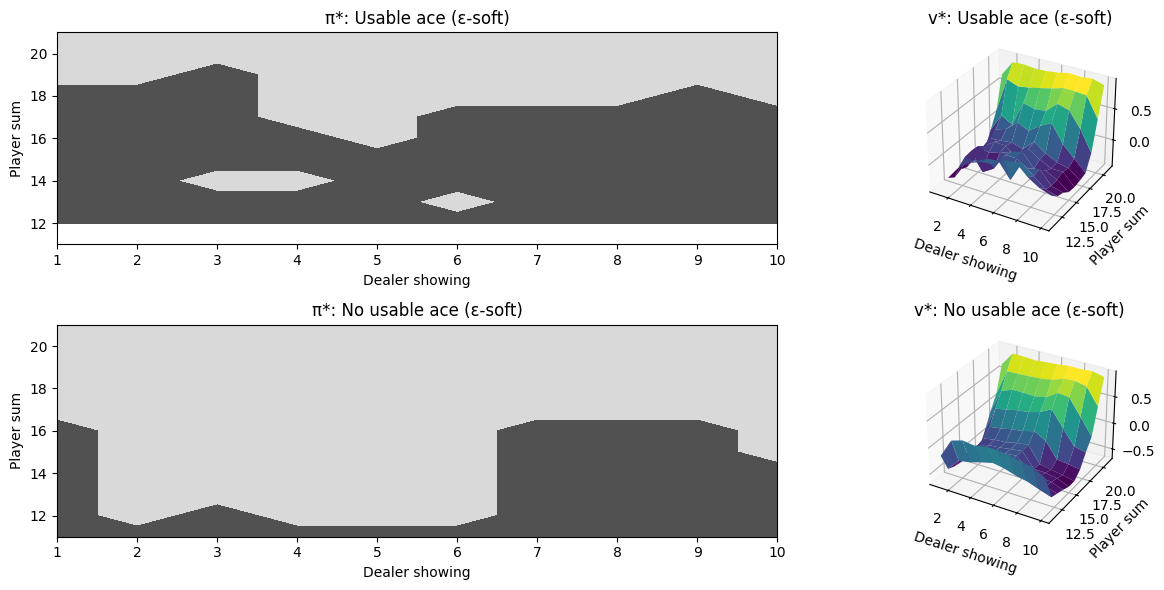

In [ ]:
player_sums = np.arange(11, 22)
dealer_showing = np.arange(1, 11)
X, Y = np.meshgrid(dealer_showing, player_sums)

Z_usable_soft = np.full_like(X, np.nan, dtype=float)
Z_no_usable_soft = np.full_like(X, np.nan, dtype=float)
policy_usable_soft = np.full_like(X, np.nan, dtype=float)
policy_no_usable_soft = np.full_like(X, np.nan, dtype=float)

for i, ps in enumerate(player_sums):
    for j, ds in enumerate(dealer_showing):
        for ace in [True, False]:
            state = (ps, ds, ace)
            if state in Q_soft:
                best_action = np.argmax(Q_soft[state])
                best_value = np.max(Q_soft[state])
                if ace:
                    Z_usable_soft[i, j] = best_value
                    policy_usable_soft[i, j] = best_action
                else:
                    Z_no_usable_soft[i, j] = best_value
                    policy_no_usable_soft[i, j] = best_action

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(221)
ax1.set_title('π*: Usable ace (ε-soft)')
ax1.contourf(dealer_showing, player_sums, policy_usable_soft, cmap='Greys', levels=[-0.5, 0.5, 1.5])
ax1.set_xlabel('Dealer showing')
ax1.set_ylabel('Player sum')

ax2 = fig.add_subplot(223)
ax2.set_title('π*: No usable ace (ε-soft)')
ax2.contourf(dealer_showing, player_sums, policy_no_usable_soft, cmap='Greys', levels=[-0.5, 0.5, 1.5])
ax2.set_xlabel('Dealer showing')
ax2.set_ylabel('Player sum')

ax3 = fig.add_subplot(222, projection='3d')
ax3.plot_surface(X, Y, Z_usable_soft, cmap='viridis')
ax3.set_title('v*: Usable ace (ε-soft)')
ax3.set_xlabel('Dealer showing')
ax3.set_ylabel('Player sum')

ax4 = fig.add_subplot(224, projection='3d')
ax4.plot_surface(X, Y, Z_no_usable_soft, cmap='viridis')
ax4.set_title('v*: No usable ace (ε-soft)')
ax4.set_xlabel('Dealer showing')
ax4.set_ylabel('Player sum')

plt.tight_layout()
plt.show()


/tmp/ipython-input-65-1409083821.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


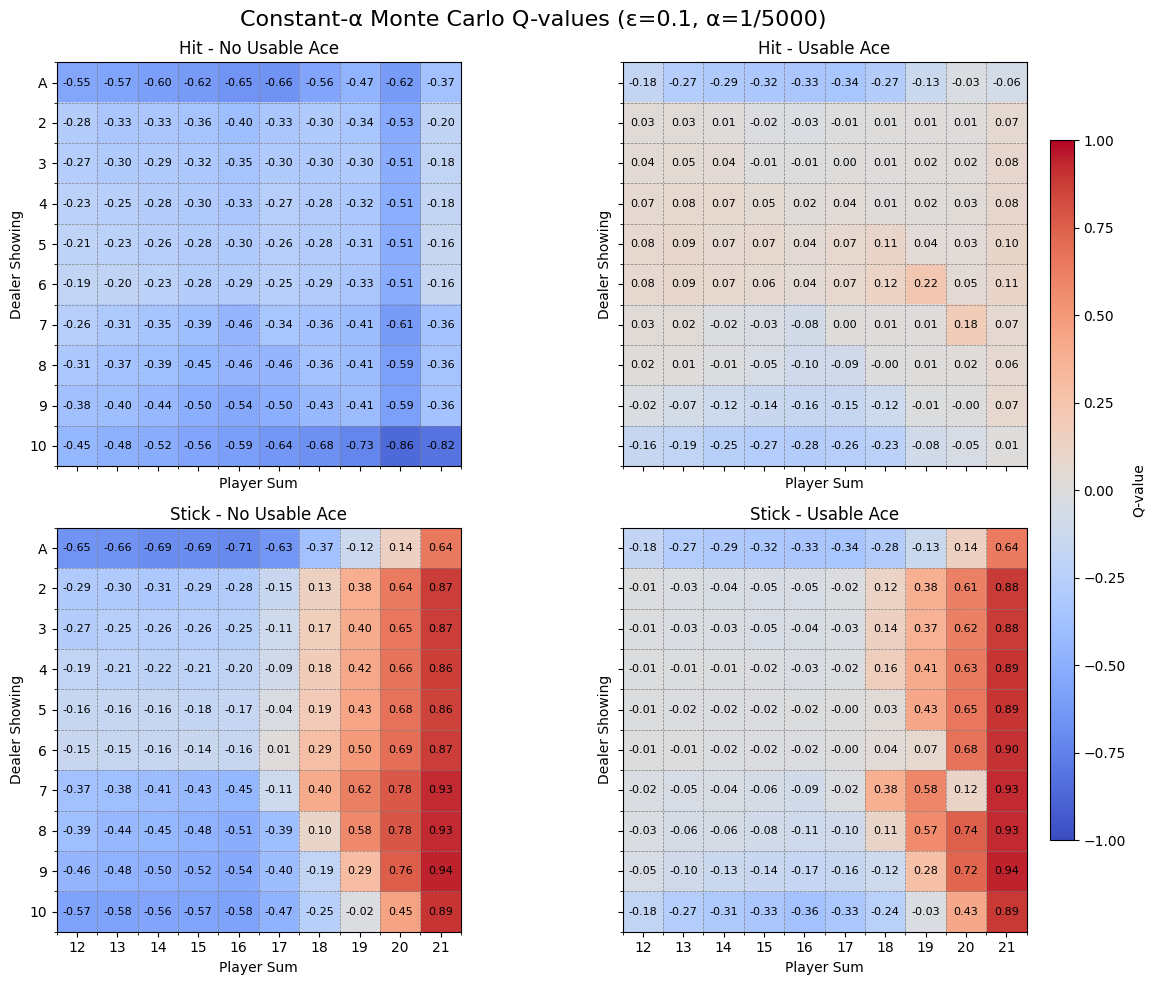

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# --- RL Setup ---
epsilon = 0.1
alpha = 1 / 5000
num_episodes = 10000000  # Can increase to 1_000_000 for better results
n_actions = 2  # 0 = Stick, 1 = Hit

def draw_card():
    return min(random.randint(1, 13), 10)

def draw_hand():
    return [draw_card(), draw_card()]

def usable_ace(hand):
    return 1 in hand and sum(hand) + 10 <= 21

def sum_hand(hand):
    total = sum(hand)
    return total + 10 if usable_ace(hand) else total

def is_bust(hand):
    return sum_hand(hand) > 21

def get_state(player, dealer_card):
    return (sum_hand(player), dealer_card, usable_ace(player))

def generate_episode(policy, Q):
    episode = []
    player = draw_hand()
    dealer = draw_hand()
    dealer_card = dealer[0]
    state = get_state(player, dealer_card)

    while True:
        action = np.random.choice([0, 1], p=policy[state])
        episode.append((state, action))
        if action == 0:
            break
        player.append(draw_card())
        if is_bust(player):
            return episode, -1
        state = get_state(player, dealer_card)

    while sum_hand(dealer) < 17:
        dealer.append(draw_card())

    player_sum = sum_hand(player)
    dealer_sum = sum_hand(dealer)

    if is_bust(dealer) or player_sum > dealer_sum:
        return episode, 1
    elif player_sum < dealer_sum:
        return episode, -1
    else:
        return episode, 0

# --- Training ---
Q = defaultdict(lambda: np.zeros(n_actions))
policy = defaultdict(lambda: np.array([0.5, 0.5]))

for _ in range(num_episodes):
    episode, reward = generate_episode(policy, Q)
    visited = set()
    for state, action in episode:
        if (state, action) not in visited:
            visited.add((state, action))
            Q[state][action] += alpha * (reward - Q[state][action])
            best_action = np.argmax(Q[state])
            for a in range(n_actions):
                policy[state][a] = (
                    1 - epsilon + epsilon / n_actions if a == best_action else epsilon / n_actions
                )

# --- Extract data for plotting ---
player_sums = np.arange(12, 22)           # X-axis
dealer_showing = np.arange(1, 11)         # Y-axis

# 10x10 matrices
q_hit_no_ace = np.full((10, 10), np.nan)
q_stick_no_ace = np.full((10, 10), np.nan)
q_hit_ace = np.full((10, 10), np.nan)
q_stick_ace = np.full((10, 10), np.nan)

for i, dc in enumerate(dealer_showing):       # dealer 1(A),2,...10
    for j, ps in enumerate(player_sums):      # player 12–21
        row = i  # row 0=A, row 9=10
        col = j  # col 0=12, col 9=21
        q_hit_no_ace[row, col] = Q[(ps, dc, False)][1]     # action=1 (hit)
        q_stick_no_ace[row, col] = Q[(ps, dc, False)][0]   # action=0 (stick)
        q_hit_ace[row, col] = Q[(ps, dc, True)][1]
        q_stick_ace[row, col] = Q[(ps, dc, True)][0]

# --- Plotting ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

titles = [["No Usable Ace", "Usable Ace"], ["No Usable Ace", "Usable Ace"]]
data = [[q_hit_no_ace, q_hit_ace], [q_stick_no_ace, q_stick_ace]]

player_labels = np.arange(12, 22)
dealer_labels = ['A'] + list(map(str, range(2, 11)))  # 1 = A

for i in range(2):  # Hit (row 0), Stick (row 1)
    for j in range(2):  # No Ace (col 0), Usable Ace (col 1)
        ax = axes[i][j]
        mat = data[i][j]
        im = ax.imshow(mat, cmap='coolwarm', vmin=-1, vmax=1)

        # Set ticks
        ax.set_xticks(np.arange(10))
        ax.set_yticks(np.arange(10))
        ax.set_xticklabels(player_labels)
        ax.set_yticklabels(dealer_labels)

        # Cell values
        for y in range(10):
            for x in range(10):
                val = mat[y, x]
                if not np.isnan(val):
                    ax.text(x, y, f"{val:.2f}", ha='center', va='center', fontsize=8)

        ax.set_title(['Hit', 'Stick'][i] + " - " + titles[i][j])
        ax.set_xlabel("Player Sum")
        ax.set_ylabel("Dealer Showing")

        ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
        ax.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)

# Shared colorbar
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label="Q-value")

fig.suptitle("Constant-α Monte Carlo Q-values (ε=0.1, α=1/5000)", fontsize=16)
plt.tight_layout()
plt.show()


/tmp/ipython-input-73-3916414983.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


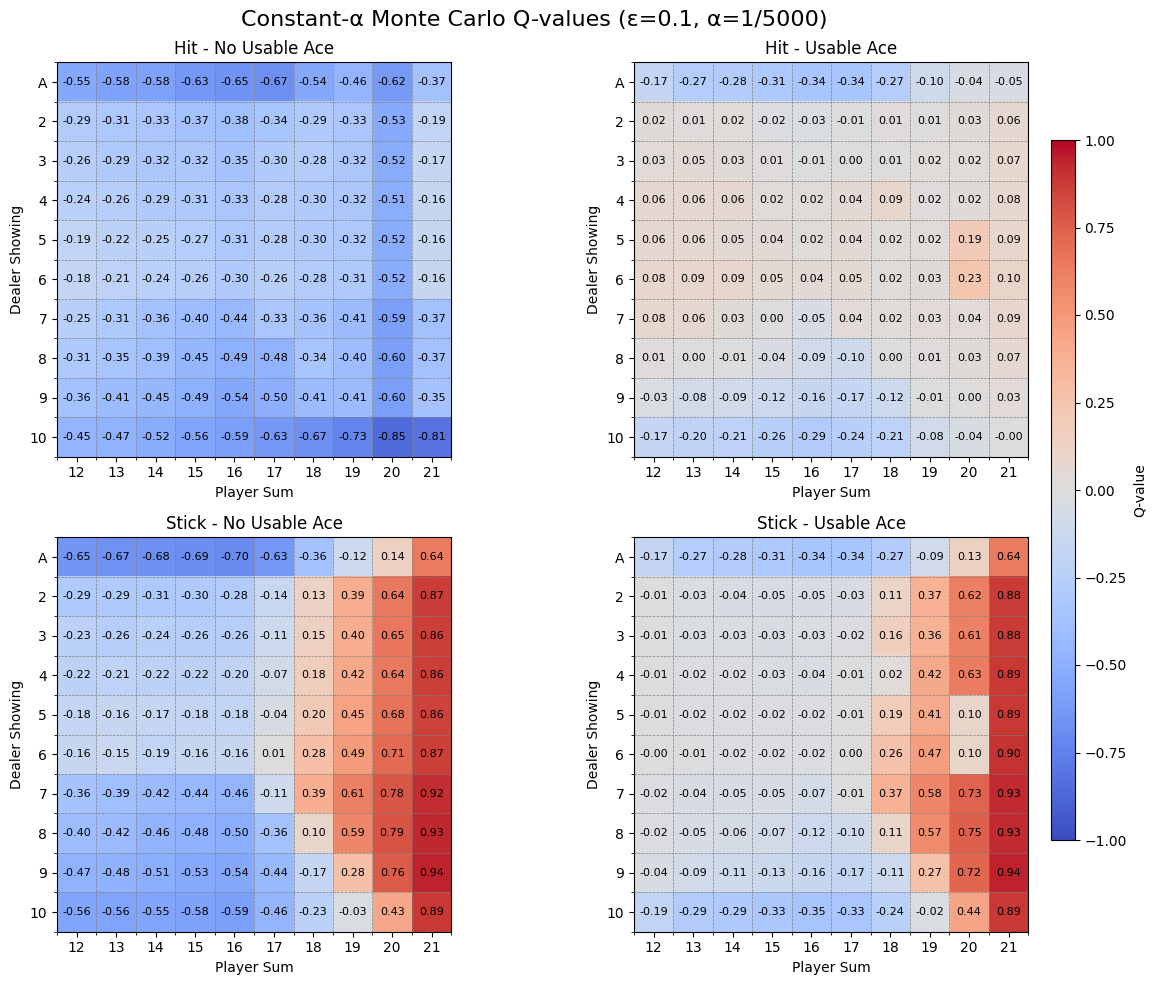

In [ ]:
# -----------------------------Constant-α Monte Carlo Q-values (ε=0.1, α=1/5000)---------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# --- RL Setup ---
epsilon = 0.1
alpha = 1 / 5000
num_episodes = 10000000
n_actions = 2  # 0 = Stick, 1 = Hit

def draw_card():
    return min(random.randint(1, 13), 10)

def draw_hand():
    return [draw_card(), draw_card()]

def usable_ace(hand):
    return 1 in hand and sum(hand) + 10 <= 21

def sum_hand(hand):
    total = sum(hand)
    return total + 10 if usable_ace(hand) else total

def is_bust(hand):
    return sum_hand(hand) > 21

def get_state(player, dealer_card):
    return (sum_hand(player), dealer_card, usable_ace(player))

def generate_episode(policy, Q):
    episode = []
    player = draw_hand()
    dealer = draw_hand()
    dealer_card = dealer[0]
    state = get_state(player, dealer_card)

    while True:
        action = np.random.choice([0, 1], p=policy[state])
        episode.append((state, action))
        if action == 0:
            break
        player.append(draw_card())
        if is_bust(player):
            return episode, -1
        state = get_state(player, dealer_card)

    while sum_hand(dealer) < 17:
        dealer.append(draw_card())

    player_sum = sum_hand(player)
    dealer_sum = sum_hand(dealer)

    if is_bust(dealer) or player_sum > dealer_sum:
        return episode, 1
    elif player_sum < dealer_sum:
        return episode, -1
    else:
        return episode, 0

# --- Training ---
Q = defaultdict(lambda: np.zeros(n_actions))
policy = defaultdict(lambda: np.array([0.5, 0.5]))

for _ in range(num_episodes):
    episode, reward = generate_episode(policy, Q)
    visited = set()
    for state, action in episode:
        if (state, action) not in visited:
            visited.add((state, action))
            Q[state][action] += alpha * (reward - Q[state][action])
            best_action = np.argmax(Q[state])
            for a in range(n_actions):
                policy[state][a] = (
                    1 - epsilon + epsilon / n_actions if a == best_action else epsilon / n_actions
                )

# --- Extract Q-values into matrices ---
player_sums = np.arange(12, 22)          # X-axis: 12–21
dealer_showing = np.arange(1, 11)        # Y-axis: 1(A),2,...,10

q_hit_no_ace = np.full((10, 10), np.nan)
q_stick_no_ace = np.full((10, 10), np.nan)
q_hit_ace = np.full((10, 10), np.nan)
q_stick_ace = np.full((10, 10), np.nan)

for i, dc in enumerate(dealer_showing):
    for j, ps in enumerate(player_sums):
        row = i      # row 0=A, row 9=10
        col = j      # col 0=12, col 9=21
        q_hit_no_ace[row, col] = Q[(ps, dc, False)][1]
        q_stick_no_ace[row, col] = Q[(ps, dc, False)][0]
        q_hit_ace[row, col] = Q[(ps, dc, True)][1]
        q_stick_ace[row, col] = Q[(ps, dc, True)][0]

# --- Plotting ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

titles = [["No Usable Ace", "Usable Ace"], ["No Usable Ace", "Usable Ace"]]
data = [[q_hit_no_ace, q_hit_ace], [q_stick_no_ace, q_stick_ace]]

player_labels = np.arange(12, 22)
dealer_labels = ['A'] + list(map(str, range(2, 11)))

for i in range(2):  # Hit / Stick
    for j in range(2):  # No Ace / Usable Ace
        ax = axes[i][j]
        mat = data[i][j]
        im = ax.imshow(mat, cmap='coolwarm', vmin=-1, vmax=1)

        # Ticks and labels
        ax.set_xticks(np.arange(10))
        ax.set_yticks(np.arange(10))
        ax.set_xticklabels(player_labels)
        ax.set_yticklabels(dealer_labels)

        # Annotate values
        for y in range(10):
            for x in range(10):
                val = mat[y, x]
                if not np.isnan(val):
                    ax.text(x, y, f"{val:.2f}", ha='center', va='center', fontsize=8)

        # Always label axes
        ax.set_xlabel("Player Sum")
        ax.set_ylabel("Dealer Showing")

        # Force tick labels visible
        ax.tick_params(labelbottom=True, labelleft=True)

        ax.set_title(['Hit', 'Stick'][i] + " - " + titles[i][j])

        # Minor grid
        ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
        ax.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)

# Shared colorbar
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label="Q-value")

fig.suptitle("Constant-α Monte Carlo Q-values (ε=0.1, α=1/5000)", fontsize=16)
plt.tight_layout()
plt.show()


## Off-policy MC control

/tmp/ipython-input-75-267486472.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


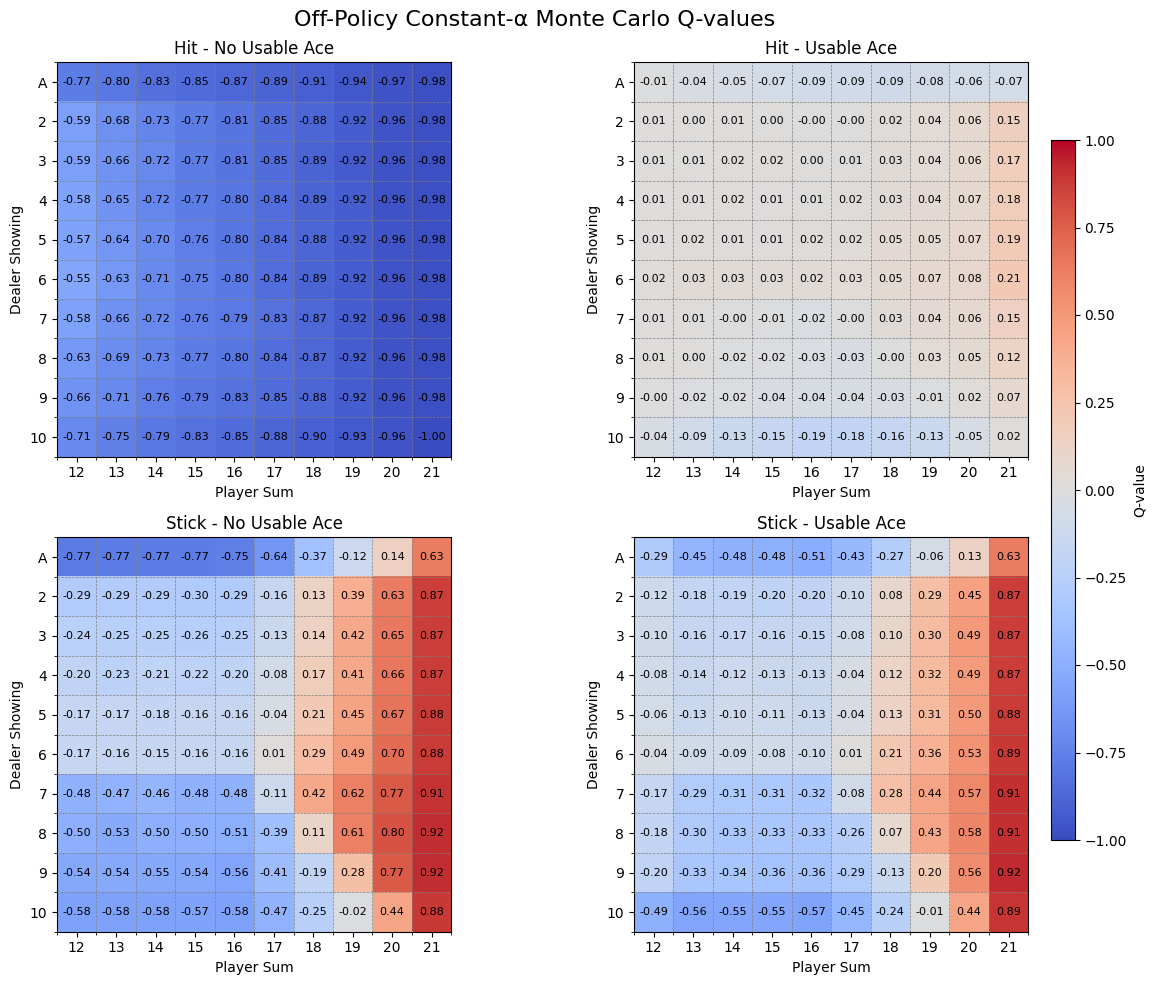

In [ ]:
# --------------Off-policy MC control-----------------------------
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# --- Setup ---
alpha = 1 / 5000
num_episodes = 10000000  # Increase for better convergence
n_actions = 2  # 0 = Stick, 1 = Hit

def draw_card():
    return min(random.randint(1, 13), 10)

def draw_hand():
    return [draw_card(), draw_card()]

def usable_ace(hand):
    return 1 in hand and sum(hand) + 10 <= 21

def sum_hand(hand):
    total = sum(hand)
    return total + 10 if usable_ace(hand) else total

def is_bust(hand):
    return sum_hand(hand) > 21

def get_state(player, dealer_card):
    return (sum_hand(player), dealer_card, usable_ace(player))

# Behavior policy: uniformly random
def generate_episode(Q):
    episode = []
    player = draw_hand()
    dealer = draw_hand()
    dealer_card = dealer[0]
    state = get_state(player, dealer_card)

    while True:
        action = np.random.choice([0, 1])
        episode.append((state, action))
        if action == 0:
            break
        player.append(draw_card())
        if is_bust(player):
            return episode, -1
        state = get_state(player, dealer_card)

    while sum_hand(dealer) < 17:
        dealer.append(draw_card())

    player_sum = sum_hand(player)
    dealer_sum = sum_hand(dealer)

    if is_bust(dealer) or player_sum > dealer_sum:
        return episode, 1
    elif player_sum < dealer_sum:
        return episode, -1
    else:
        return episode, 0

# Target policy: greedy
def target_policy(Q, state):
    return np.argmax(Q[state])

# Initialize
Q = defaultdict(lambda: np.zeros(n_actions))
C = defaultdict(float)

# --- Training Loop ---
for _ in range(num_episodes):
    episode, reward = generate_episode(Q)
    G = reward
    W = 1.0
    for state, action in reversed(episode):
        C[(state, action)] += W
        Q[state][action] += alpha * W * (G - Q[state][action])
        if action != target_policy(Q, state):
            break
        W *= 0.5  # π(a|s)=1, b(a|s)=0.5

# --- Q-table to matrices ---
player_sums = np.arange(12, 22)
dealer_showing = np.arange(1, 11)

q_hit_no_ace = np.full((10, 10), np.nan)
q_stick_no_ace = np.full((10, 10), np.nan)
q_hit_ace = np.full((10, 10), np.nan)
q_stick_ace = np.full((10, 10), np.nan)

for i, dc in enumerate(dealer_showing):
    for j, ps in enumerate(player_sums):
        row = i
        col = j
        q_hit_no_ace[row, col] = Q[(ps, dc, False)][1]
        q_stick_no_ace[row, col] = Q[(ps, dc, False)][0]
        q_hit_ace[row, col] = Q[(ps, dc, True)][1]
        q_stick_ace[row, col] = Q[(ps, dc, True)][0]

# --- Plotting ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

titles = [["No Usable Ace", "Usable Ace"], ["No Usable Ace", "Usable Ace"]]
data = [[q_hit_no_ace, q_hit_ace], [q_stick_no_ace, q_stick_ace]]

player_labels = np.arange(12, 22)
dealer_labels = ['A'] + list(map(str, range(2, 11)))

for i in range(2):  # Hit / Stick
    for j in range(2):  # No Ace / Usable Ace
        ax = axes[i][j]
        mat = data[i][j]
        im = ax.imshow(mat, cmap='coolwarm', vmin=-1, vmax=1)

        ax.set_xticks(np.arange(10))
        ax.set_yticks(np.arange(10))
        ax.set_xticklabels(player_labels)
        ax.set_yticklabels(dealer_labels)

        for y in range(10):
            for x in range(10):
                val = mat[y, x]
                if not np.isnan(val):
                    ax.text(x, y, f"{val:.2f}", ha='center', va='center', fontsize=8)

        ax.set_xlabel("Player Sum")
        ax.set_ylabel("Dealer Showing")
        ax.tick_params(labelbottom=True, labelleft=True)
        ax.set_title(['Hit', 'Stick'][i] + " - " + titles[i][j])
        ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
        ax.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)

fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label="Q-value")
fig.suptitle("Off-Policy Constant-α Monte Carlo Q-values", fontsize=16)
plt.tight_layout()
plt.show()


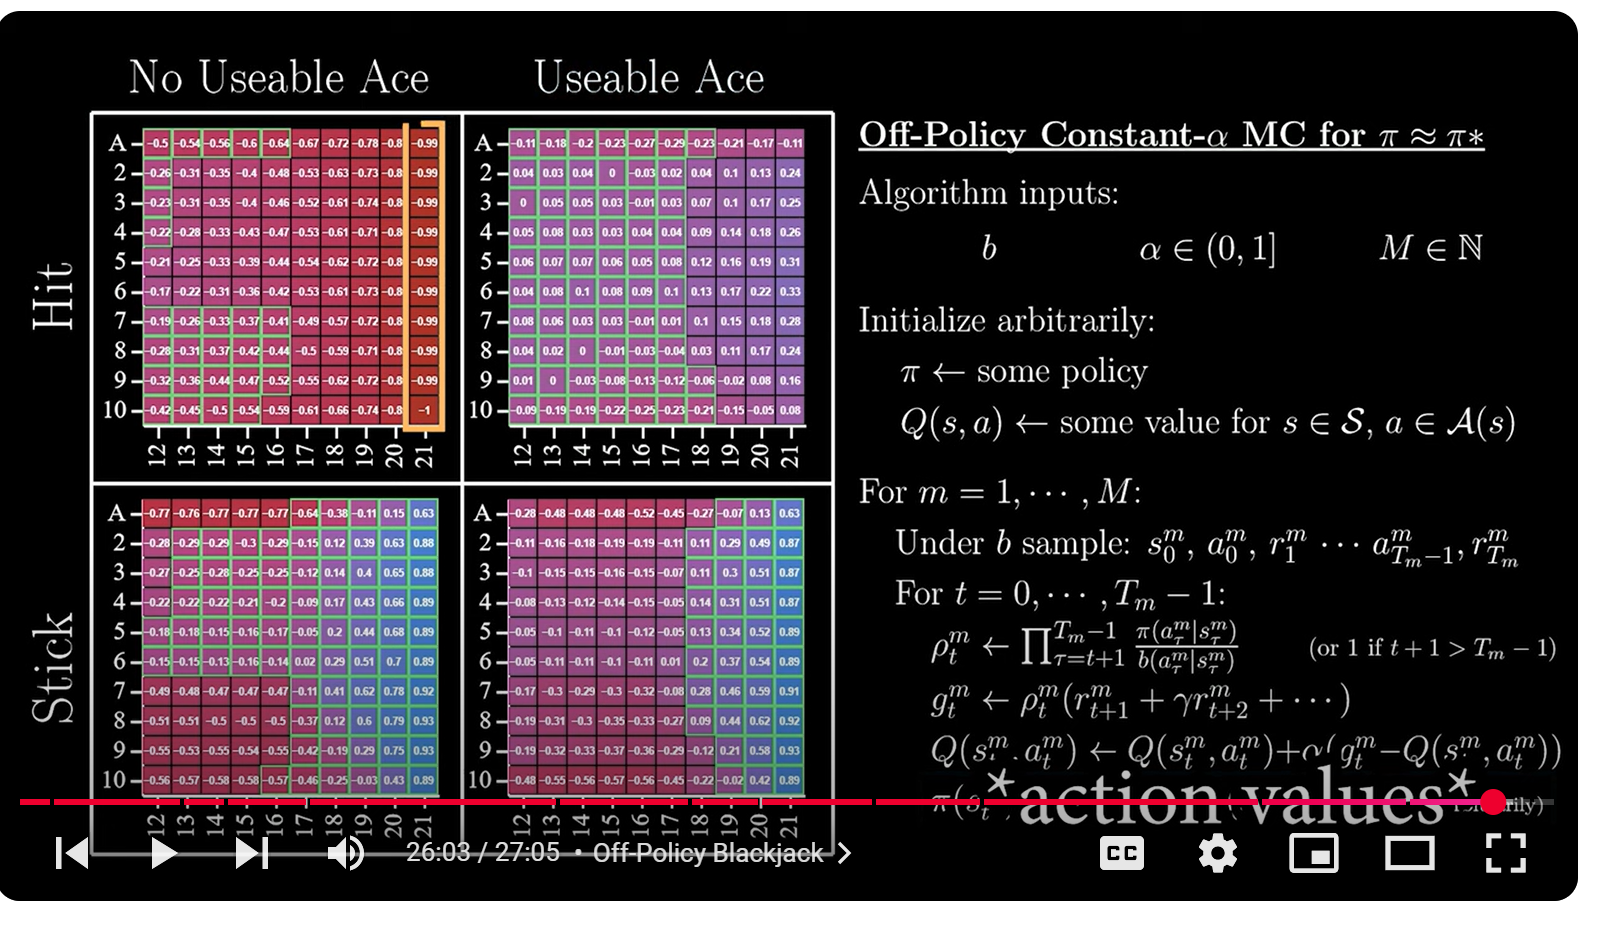

# Greedy K-armed Bandit

In [ ]:
# ----------------------Greedy K-armed Bandit----------------------------------------
# Simple, Non-stationary
import numpy as np
import random

# Number of arms (k-armed bandit)
k = 10
epsilon = 0.1  # exploration rate
steps = 1000   # number of steps to run

# Initialize estimated values and counts
Q = np.zeros(k)   # Q(a): estimated value of action a, Q = array([0,0,0,0,0,0,0,0,0,0]), Q[a] holds the estimated average reward of arm a.
N = np.zeros(k)   # N(a): number of times action a has been selected, N = array([0,0,0,0,0,0,0,0,0,0]), N[a] counts how many times arm a was pulled.

# Simulated bandit with true reward means for each arm
true_means = np.random.normal(0, 1, k)  # unknown to the algorithm, create a array of 10 elements, each element from normal distribution N(0,1)
# array([ 0.05625525, -1.37777665,  1.18099952,  0.54817673,  0.34339132, 0.56317327, -1.55359995, -0.06306481, -0.19473105,  0.56056883])
# true_mean=[No.arm=0, No.arm=1  ,  No.arm=2  ,  No.arm=3  ,  No.arm=4  ,  No.arm=5 ,  No.arm= 6 ,  No.arm=7  ,  No.arm=8  ,  No.arm=9 ]
# true_mean[0]=0.56255

def bandit(a): # bandit(a)= No.a arm's random reward
    """Simulate pulling arm a (return a random reward)"""
    return np.random.normal(true_means[a], 1) # generates a single random number drawn from a normal distribution with true_mean[a],variance=1, np.random.normal(true_means[0],1)=0.7167

# Run ε-greedy bandit algorithm. With probability ε, the algorithm explores a random arm.
for step in range(steps):
    if random.random() < epsilon: # random.random() gives a new uniformly random number in [0,1)
        A = random.randint(0, k - 1)  # explore: random action # random.randint(0,9) return an integer in [0,9]
    else: # a random number > epsilon
        max_value = np.max(Q) # get the max value of Q = array([xx,xx,xx,xx,xx,xx,xx,xx,xx,xx])
        candidates = np.where(Q == max_value)[0] # np.where() returns a tuple because np designed to work on multi-dimensional arrays, not just 1D vectors.
        A = np.random.choice(candidates)  # break ties randomly

    R = bandit(A)        # get reward
    N[A] += 1            # update count
    Q[A] += (R - Q[A]) / N[A]  # incremental update

# Print final estimated values
for a in range(k):
    print(f"Arm {a}: Estimated value = {Q[a]:.3f}, True mean = {true_means[a]:.3f}, Pulled {int(N[a])} times")